In [1]:
library(dplyr)
library(ggnewscale)
library(ggplot2)
library(ggtree)
library(latex2exp)
library(RColorBrewer)
library(scales)
library(stringr)
library(tidyr)
library(treeio)

Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggnewscale’ was built under R version 4.1.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

ggtree v3.2.0  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution. 2018, 35(12):3041-3043. doi:10.10

In [2]:
diff <- read.table("../results/relman_abx/birdman_results.beta_var.tsv", sep="\t", header=1, row.names=1)
diff <- diff %>% 
    select(ends_with("mean")) %>%
    select(starts_with("C"))
diff$id <- sub("F", "", row.names(diff))
row.names(diff) <- diff$id
head(diff)

,C.antibiotic..Diff..levels..preCp..FirstCp..FirstWPC..Interim..SecondCp..SecondWPC..PostCp...D.preCp._mean,C.antibiotic..Diff..levels..preCp..FirstCp..FirstWPC..Interim..SecondCp..SecondWPC..PostCp...D.FirstCp._mean,C.antibiotic..Diff..levels..preCp..FirstCp..FirstWPC..Interim..SecondCp..SecondWPC..PostCp...D.FirstWPC._mean,C.antibiotic..Diff..levels..preCp..FirstCp..FirstWPC..Interim..SecondCp..SecondWPC..PostCp...D.Interim._mean,C.antibiotic..Diff..levels..preCp..FirstCp..FirstWPC..Interim..SecondCp..SecondWPC..PostCp...D.SecondCp._mean,C.antibiotic..Diff..levels..preCp..FirstCp..FirstWPC..Interim..SecondCp..SecondWPC..PostCp...D.SecondWPC._mean,id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
174654,-4.2163787,-3.813427,2.4973956,-1.377877,1.41810086,-3.8153727,174654
833381,0.5282930,-2.952751,1.4877139,-4.991274,3.40954665,0.4520929,833381
4398588,-2.1222778,1.564044,4.8135014,-1.153654,-0.07621658,-5.5636839,4398588
4457453,-2.9055523,-1.442756,3.7418850,-1.544690,0.54385643,-12.4351932,4457453
215097,-0.9763971,2.150305,-3.6233665,-1.059936,-1.46127899,-0.9978636,215097
336761,-1.8924092,2.219522,0.2560585,2.464965,-0.46620548,1.1861078,336761


In [3]:
levels <- c("preCp", "FirstCp", "FirstWPC", "Interim", "SecondCp", "SecondWPC", "PostCp")
levels_diffs <- c()
for (i in c(2:length(levels))) {
    diff_name <- paste0(levels[i], " vs ", levels[i-1])
    levels_diffs <- c(levels_diffs, diff_name)
}
colnames(diff) <- c(levels_diffs, "id")
head(diff)

,FirstCp vs preCp,FirstWPC vs FirstCp,Interim vs FirstWPC,SecondCp vs Interim,SecondWPC vs SecondCp,PostCp vs SecondWPC,id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
174654,-4.2163787,-3.813427,2.4973956,-1.377877,1.41810086,-3.8153727,174654
833381,0.5282930,-2.952751,1.4877139,-4.991274,3.40954665,0.4520929,833381
4398588,-2.1222778,1.564044,4.8135014,-1.153654,-0.07621658,-5.5636839,4398588
4457453,-2.9055523,-1.442756,3.7418850,-1.544690,0.54385643,-12.4351932,4457453
215097,-0.9763971,2.150305,-3.6233665,-1.059936,-1.46127899,-0.9978636,215097
336761,-1.8924092,2.219522,0.2560585,2.464965,-0.46620548,1.1861078,336761


In [4]:
tree_loc <- "../data/relman_abx/ref/97_otus.tree"
tree <- treeio::read.tree(tree_loc)
tips_to_drop <- setdiff(tree$tip.label, diff$id)
tree_reduced <- treeio::drop.tip(tree, tips_to_drop)
tree_reduced


Phylogenetic tree with 822 tips and 821 internal nodes.

Tip labels:
  4457296, 269386, 4422313, 4449236, 4474255, 1602307, ...
Node labels:
  , , 'p__Cyanobacteria', , , , ...

Rooted; includes branch lengths.

In [5]:
tax_loc <- "../data/relman_abx/ref/97_otu_taxonomy.txt"
tax <- read.table(tax_loc, sep="\t", row.names=1, quote="")
colnames(tax) <- c("Taxon")
tax$id <- row.names(tax)
tax$genus <- stringr::str_match(tax$Taxon, "g__(.*);")[, 2]
tax$genus[tax$genus == ""] <- NA
tax$genus <- tidyr::replace_na(tax$genus, "Other")
tax <- tax[row.names(tax) %in% tree_reduced$tip.label,]
dim(tax)
head(tax)

[1] 822   3

,Taxon,id,genus
,<chr>,<chr>,<chr>
2626509,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__,2626509,Other
292243,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__; s__,292243,Other
4325533,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Rikenellaceae; g__; s__,4325533,Other
174019,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Coprococcus; s__,174019,Coprococcus
335719,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__; s__,335719,Other
193850,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__; s__,193850,Other


In [6]:
genus_df <- tax %>% select(c("genus"))
head(genus_df)

,genus
,<chr>
2626509,Other
292243,Other
4325533,Other
174019,Coprococcus
335719,Other
193850,Other


In [7]:
genus_counts <- as.data.frame(table(genus_df))
head(genus_counts)

,genus_df,Freq
,<fct>,<int>
1,[Eubacterium],3
2,[Ruminococcus],11
3,Actinobacillus,1
4,Actinomyces,3
5,Adlercreutzia,2
6,Akkermansia,7


In [8]:
all_genera <- unique(genus_df$genus)
top_genera <- as.vector((genus_counts %>% filter(Freq >= 10) %>% filter(genus_df != "Other"))$genus_df)

genus_vector <- c()
genus_list <- list()

for (i in 1:nrow(tax)) {
    row <- tax[i, ]
    this_genus <- row$genus
    if (this_genus %in% top_genera) {
        genus_vector <- c(genus_vector, this_genus)
        genus_list[[this_genus]] <- c(genus_list[[this_genus]], row$id)
    } else if (!(this_genus %in% top_genera)) {
        genus_vector <- c(genus_vector, "Other")
        genus_list$Other <- c(genus_list$Other, row$id)
    } else {
        print("boop")
    }
}

genus_colors <- c(RColorBrewer::brewer.pal(length(top_genera) , "Set1"), "lightgray")
names(genus_colors) <- c(top_genera, "Other")
genus_colors

[Ruminococcus]      Bacteroides          Blautia      Coprococcus 
       "#E41A1C"        "#377EB8"        "#4DAF4A"        "#984EA3" 
Faecalibacterium     Oscillospira        Roseburia     Ruminococcus 
       "#FF7F00"        "#FFFF33"        "#A65628"        "#F781BF" 
           Other 
     "lightgray"

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



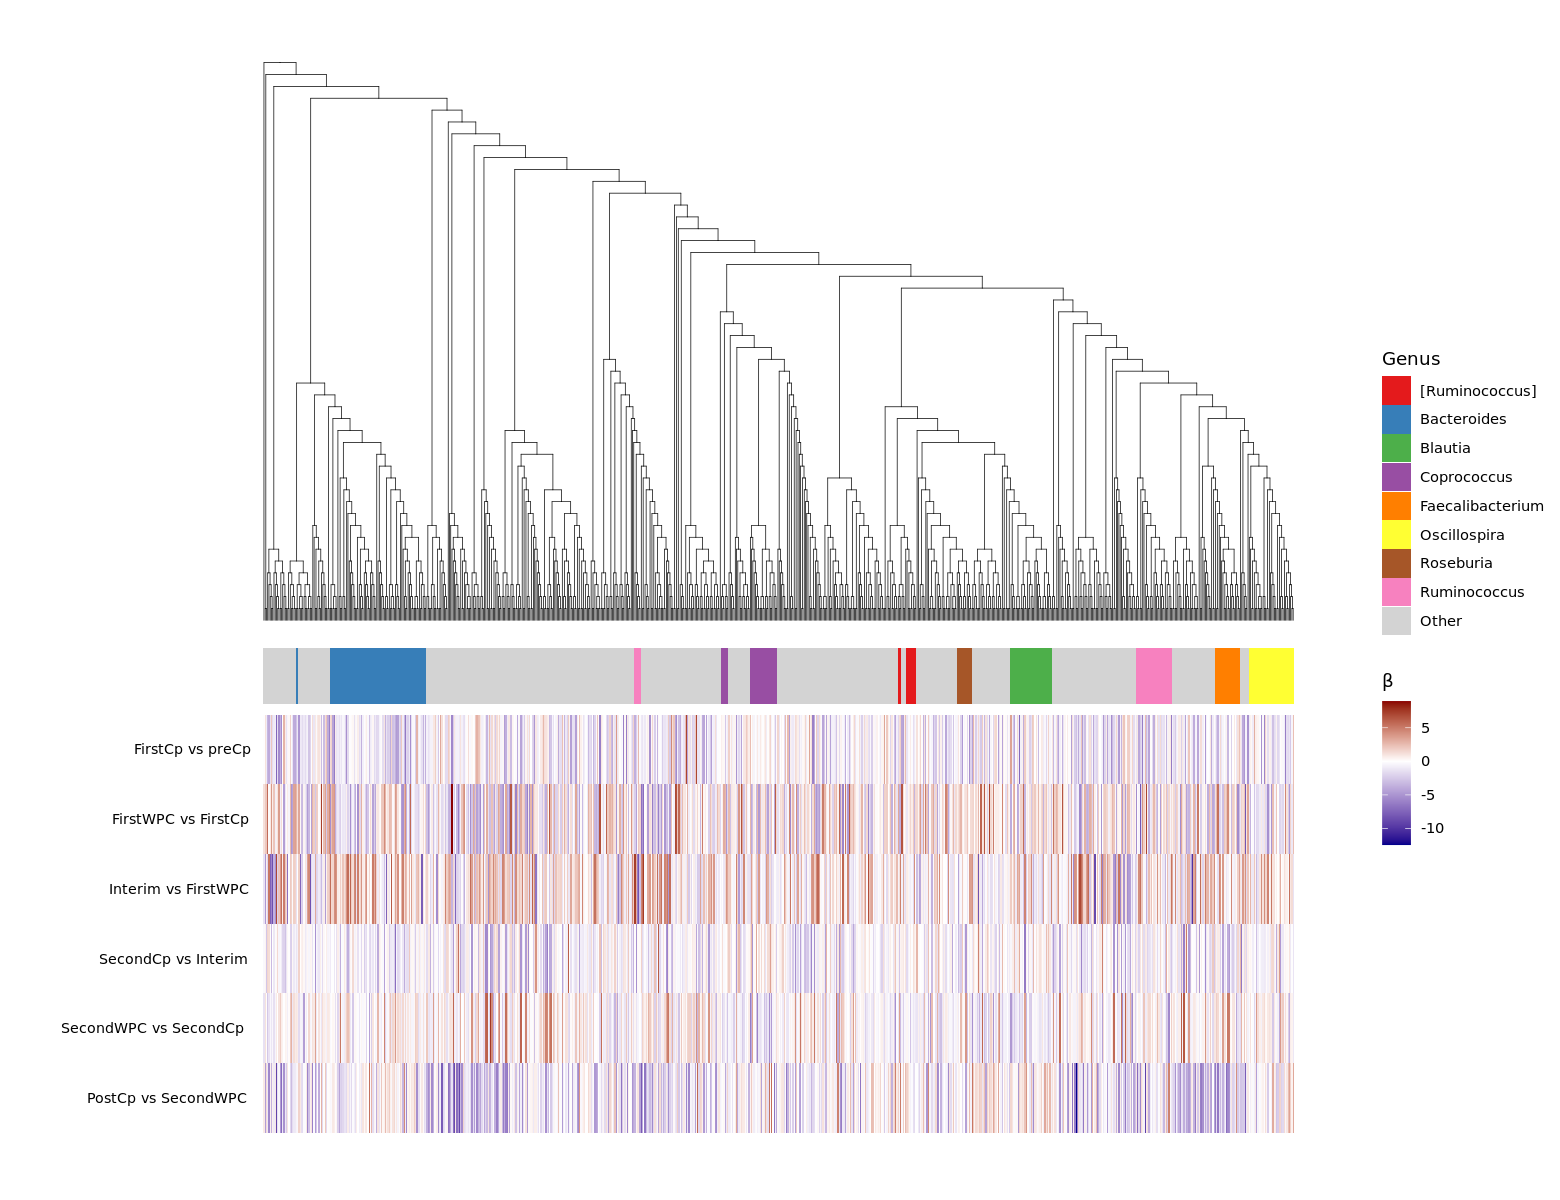

In [9]:
options(repr.plot.width=13, repr.plot.height=10)

genus_color_df <- as.data.frame(genus_vector)
row.names(genus_color_df) <- row.names(tax)

min_val <- min(diff %>% select(-c("id")))
max_val <- max(diff %>% select(-c("id")))

p1 <- ggtree::ggtree(tree_reduced, branch.length = "none", color = "black", size = 0.2) +
    layout_dendrogram()

p2 <- ggtree::gheatmap(p1, genus_color_df, color = NA, offset = 0, colnames = FALSE, width = 0.1, hjust=0) +
    ggplot2::scale_fill_manual(values = genus_colors, name = "Genus", breaks = c(top_genera, "Other"),
                               na.value = "black")

p3 <- p2 + ggnewscale::new_scale_fill()

p4 <- ggtree::gheatmap(p3, diff %>% select(-c("id")), offset = 5, width = 0.75, color = NA,
                       colnames_angle = 0, font.size = 3,
                       hjust = 1.1) +
    ggplot2::scale_fill_gradientn(colors = c("darkblue", "white", "darkred"),
                                  values = scales::rescale(c(min_val, 0, max_val)),
                                  na.value = "black", name = latex2exp::TeX("$\\beta$")) +
    ylim(-150, NA) # Used to fit labels

ggplot2::ggsave("../figures/relman_abx/phylo_tree.pdf", p4, bg = "white", dpi = 330,
                width = 12, height = 6)
show(p4)